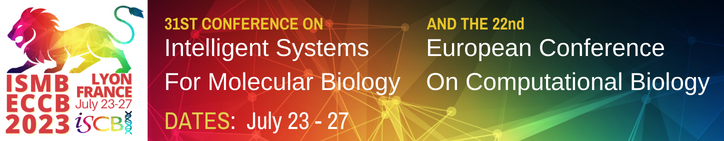

#**VT2: Protein Sequence Analysis using Transformer-based Large Language Model**

## **Part-2C : Case study 2: Metal Binding Site Prediction**

31st Conference on Intelligent Systems for Molecular Biology (ISMB) /
22nd European Conference on Computational Biology (ECCB)

**Venue:** Hybrid (Virtual/Lyon,France)

**Date of the session:** July 17-18, 2023

**Instructor :** Bishnu Sarker, PhD

**Affiliation :** Meharry Medical College, TN, USA.


Please cite this tutorial as:

**Bishnu Sarker, Sayane Shome, Farzana Rahman, Nima Aghaeepour (2023, July). Tutorial VT2: Protein Sequence Analysis using Transformer-based Large Language Model. In 31st Conference on Intelligent Systems for Molecular Biology and 22nd European Conference on Computational Biology (ISMB/ECCB 2023), Lyon, France.**

### Metal Binding ability of Proteins

Proteins have the ability to interact with metals like copper, zinc, magnesium, and others, playing diverse roles such as facilitating metal import/export, transportation within the cell, and maintaining stable protein structure. These interactions occur at specific locations on the protein called metal binding sites, where a single amino acid position binds to a metal ion. However, the manual identification of these metal binding sites is a costly, labor-intensive, and time-consuming process. Only a small fraction of the vast number of proteins in UniProtKB, the most comprehensive protein database, are currently annotated with metal binding sites, leaving a considerable number of proteins awaiting such annotations.Hence, to keep up with annotating this vast expanding number of proteins being predicted, the development of a computational pipelines becomes crucial. However, a notable limitation of current computational methods is the insufficient incorporation of long-term residue dependencies. [(Shishir et. al)](https://link.springer.com/chapter/10.1007/978-3-031-34960-7_4). Transformer-based language models have shown to model long sequence dependency without suffering from vanishing gradient problem is of prime interest now to build metal ion prediction models.

Similar to the case study undertaken in Part-2B,  we will be using pre-generated embeddings downloaded from Uniprot(https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5)

Ideally, one should be using a pre-trained model to generate the embeddings against the amino acid sequences. However, as we have mentioned earlier, due to resource constraints, it is infeasible to generate the embeddings inline for a bulk size of input sequences.

In this case study, we will follow below steps to gather embeddings:
1. We have mapped the structure ID given in our dataset to UniProt Entry ID by using the following services from UniProtKB: https://www.uniprot.org/id-mapping
2. We have downloaded UniProtKB/SwissProt embeddings from https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5

These embeddings are generated by using [ProtT5](https://arxiv.org/pdf/2007.06225.pdf) model as we explained in the previous session. In the embedding file, a UniProtKB protein ID is linked to an embedding generated by running ProtT5 encoder model on the corresponding amino acid sequence.

3.  With some further data processing, we have prepared a Pandas DataFrame associated embeddings to their IDs and labels.
4. And finally we save the DataFrame as a pickle file for quick and easier loading for the future purposes.

In summary, the objectives in the case study are:

1. Data loading, pre-processing and formatting to generate embeddings.
2. Building a logistic regression model to predict the metal-ions that bind a protein.

### Import Packages

In [1]:
# Loading general data science packages
import pandas as pd
import numpy as np

# For visualization support,we will load matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

# package for random choice generation
import random
from random import sample

# for machine learning tasks,we are loading pytorch and scikit-learn
import sklearn as sk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import h5py

### Loading Data

In this step, we will load both the data file: 1) sequence file, 2) embeddings.

In [2]:
## Loading data
from google.colab import drive
drive.mount('/content/drive')

## Setting working directory
%cd /content/drive/MyDrive/ISMB_ECCB_2023



Mounted at /content/drive
/content/drive/MyDrive/ISMB_ECCB_2023


The dataset we are going to use for this case study is shared by [European Bioinformatics Institute EBI](https://www.ebi.ac.uk/) as part of the challenge on metal binding site prediction. Original files are accessible here: https://www.synapse.org/#!Synapse:syn50559353

The dataset is further pre-processed and cleaned to include metal ions as [ChEBI](https://www.ebi.ac.uk/chebi/) ids.

Loading the cleaned dataset

In [3]:
data_path="data/ebi_challenge_data_metal.csv"
data=pd.read_csv(data_path, sep='\t', header=None)

In [4]:
data.head(3)

,0,1,2,3
0,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,"12,10,10,8,19,24,19,14","CHEBI:29108,CHEBI:29108,CHEBI:29035,CHEBI:2903..."
1,A0A067XG71,ADTIVAVELDTYPNTDIGDPNYPHIGIDIKSIRSKKIAKWNMQDGK...,"12,8,10,10,8,19,14,19,10,19,24,19,12,24,14,10","CHEBI:29108,CHEBI:29035,CHEBI:29035,CHEBI:2910..."
2,A0A084JZF2,MRKLKYNTTRVILMIAFISLSACSSEDAMIEEEQVIPDPDPVAQTD...,"81,61,85,84,79,59","CHEBI:29108,CHEBI:29108,CHEBI:29108,CHEBI:2910..."


The dataframe comprises of first,second,third and fourth columns as Uniprotid, sequence, binding sites, and metal ions respectively.

Loading the embedding file.

Using the UniProtKB reviewed proteins embeddings, we have added a new column to the dataset for embeddings.

In [5]:
embedding_df=pd.read_pickle('data/case_study_2.pkl') # we are loading the processed dataframe as pickle file

In [6]:
embedding_df.head(3)

,uniprotId,sequence,site,metal,embeddings
0,A0A023GPI8,ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGK...,"12,10,10,8,19,24,19,14","CHEBI:29108,CHEBI:29108,CHEBI:29035,CHEBI:2903...","[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,..."
1,A0A067XG71,ADTIVAVELDTYPNTDIGDPNYPHIGIDIKSIRSKKIAKWNMQDGK...,"12,8,10,10,8,19,14,19,10,19,24,19,12,24,14,10","CHEBI:29108,CHEBI:29035,CHEBI:29035,CHEBI:2910...","[0.02753, -0.0004737, 0.03107, -0.04092, 0.007..."
2,A0A084JZF2,MRKLKYNTTRVILMIAFISLSACSSEDAMIEEEQVIPDPDPVAQTD...,"81,61,85,84,79,59","CHEBI:29108,CHEBI:29108,CHEBI:29108,CHEBI:2910...","[0.0908, -0.03021, -0.00632, 0.00622, -0.00230..."


In [ ]:
len(embedding_df)


2317

#### Further preprocessing

The problem of metal binding site prediction typically involves estimating the position in a protein sequence where a specific metal ion binds. Ideally, a model designed for this task should provide two outputs: 1) the predicted binding site and 2) the predicted binding metal ion.

However, previous research has primarily focused on predicting the metal ion given an input sequence and a specific residue position. In other words, the sequence is scanned from the start to the end to determine the metal ion that binds to a particular position.

In this case study, our objective is to develop a model that takes both the protein sequence and a specific position as inputs, and predicts the corresponding metal ion that binds at that position. By leveraging this approach, we can explore the relationship between protein sequences, residue positions, and the associated metal ions, enabling accurate metal binding prediction.

For that reason, we will restructure the dataset by carrying out following data preprocessing :


1.To accurately represent the binding sites of metal ions within a protein sequence, each sequence is replicated multiple times based on the number of binding sites it has. For example, if the first sequence has nine binding sites, it will be replicated nine times. Each replicated sequence is then associated with a single residue position and a single metal ion, capturing the specific binding information.
2.Each sequence is represented using a 1024-dimensional embedding. These embeddings encode the contextual information and characteristics of the amino acid sequence, providing a rich numerical representation of the protein.

3.Additionally, each binding site is represented using a positional vector, which contains information about the relative position of the binding site within the sequence. This positional vector is added to the corresponding sequence embedding before feeding it into the machine learning model. By incorporating the positional vector, the model can learn the positional importance of each binding site during the prediction process.
4.Finally, a data matrix X is created, which combines the sequence embeddings and the positional vectors. This matrix serves as the input to the machine learning model. A label vector Y is also prepared, containing the corresponding metal ion labels for each binding site. These labels represent the target variable that the model aims to predict.



##### **data_preparation()**

In [7]:
def data_preparation(df, cols=['uniprotId', 'sequence', 'site', 'metal', 'embeddings']):
  X=[]
  binding_sites=[]
  Y=[]

  embeds=list(df[cols[4]])
  site=list(df[cols[2]])
  metal=list(df[cols[3]])

  for i in range(len(site)):

    embed=embeds[i]

    sites=[int(j) for j in site[i].split(',')]

    metals=[j.strip() for j in metal[i].split(',')]

    X=X+[embed]*len(sites)
    binding_sites=binding_sites+sites
    Y=Y+metals

  return pd.DataFrame({'embedding':X, 'site':binding_sites, 'metal':Y})

In [8]:
embedding_df=data_preparation(embedding_df)
embedding_df.head(10)

,embedding,site,metal
0,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",12,CHEBI:29108
1,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",10,CHEBI:29108
2,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",10,CHEBI:29035
3,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",8,CHEBI:29035
4,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",19,CHEBI:29108
5,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",24,CHEBI:29035
6,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",19,CHEBI:29035
7,"[0.01456, 0.00906, 0.02852, -0.03986, 0.00624,...",14,CHEBI:29108
8,"[0.02753, -0.0004737, 0.03107, -0.04092, 0.007...",12,CHEBI:29108
9,"[0.02753, -0.0004737, 0.03107, -0.04092, 0.007...",8,CHEBI:29035


In [ ]:
embedding_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18043 entries, 0 to 18042
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   embedding  18043 non-null  object
 1   site       18043 non-null  int64 
 2   metal      18043 non-null  object
dtypes: int64(1), object(2)
memory usage: 423.0+ KB


Finally, we have a dataset with 18043 number of records. Each record contains an embedding, a binding site and a ChEBI id to the metal ion it binds.

#### Positional encoding

Transformers uses positional encoding to keep track of the order of words/tokens in a sequence. Following similar principle, instead of using one hot encoding, in this case study, we will use positional encoding to get a fixed dimensional vector for each position. A comprehensive explanation of positional encoding can be found [here](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1)

In [9]:
def position_embeddings(max_binding_position, d=1024, n=10000):
    P = np.zeros((max_binding_position, d))

    for k in range(max_binding_position):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

In [30]:
max(embedding_df.site)

5038

In [10]:
max_binding_site=max(embedding_df.site)+1
pos_encodings=position_embeddings(max_binding_site)

In [12]:
pos_encodings.shape

(5039, 1024)

In [32]:
t=pos_encodings[20, :]

In [33]:
t.shape

(1024,)

To retrieve positional encoding for a particular binding site, for example, 12-residue position,we will print as follows :

In [13]:
print(pos_encodings[12, :])

[-0.53657292  0.84385396 -0.70349831 ...  0.99999923  0.00122178
  0.99999925]


In [14]:
print(pos_encodings[13, :])

[0.42016704 0.90744678 0.20049577 ... 0.99999909 0.0013236  0.99999912]


##### Exploratory Data Analysis

In [15]:
X_X=list(embedding_df.embedding)
Y=list(embedding_df.metal)
labels=list(set(Y))


Checking number of Unique labels in the dataset

In [16]:
n_labels=len(labels)
n_labels

23

Adding positional encoding with embeddings

In [17]:
X_site=list(embedding_df.site)
X_site=list(map(lambda x: pos_encodings[x, :], X_site))
X_and_site=[x+s for x,s in zip(X_X, X_site)]
len(X_and_site)

18043

In [18]:
len(X_and_site[0])

1024

Distribution of instances based on metal ions

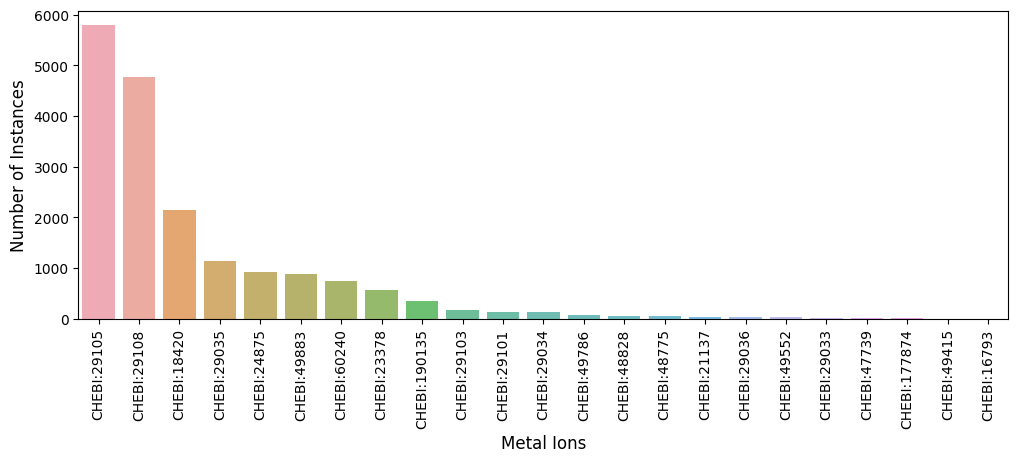

In [20]:
cnt_pro = embedding_df['metal'].value_counts()
plt.figure(figsize=(12,4))
#print(cnt_pro)
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Instances', fontsize=12)
plt.xlabel('Metal Ions', fontsize=12)
plt.xticks(rotation=90)
plt.show();

#### Logistic Regression

Now let's build a simple logistic regression model for multi-label classification.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [22]:
X=X_and_site

In [23]:
len(X)

18043

In [24]:
x_train, x_test, y_train, y_test=train_test_split(X,Y, test_size=0.2, random_state=120, stratify=Y)

In [25]:
model=LogisticRegression(penalty='l2', max_iter=300)
model.fit(x_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

In [26]:
cr=classification_report(model.predict(x_test), y_test)
print(cr)

              precision    recall  f1-score   support

CHEBI:177874       0.00      0.00      0.00         0
 CHEBI:18420       0.73      0.70      0.72       448
CHEBI:190135       0.81      0.95      0.88        60
 CHEBI:21137       0.29      0.67      0.40         3
 CHEBI:23378       0.79      0.92      0.85        96
 CHEBI:24875       0.62      0.73      0.67       158
 CHEBI:29033       0.00      0.00      0.00         2
 CHEBI:29034       0.59      0.62      0.60        26
 CHEBI:29035       0.48      0.63      0.55       174
 CHEBI:29036       0.14      0.25      0.18         4
 CHEBI:29101       0.52      0.68      0.59        22
 CHEBI:29103       0.24      0.50      0.33        16
 CHEBI:29105       0.85      0.77      0.81      1280
 CHEBI:29108       0.92      0.84      0.88      1037
 CHEBI:47739       0.00      0.00      0.00         0
 CHEBI:48775       0.60      1.00      0.75         6
 CHEBI:48828       0.00      0.00      0.00         0
 CHEBI:49415       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report generates a comprehensive report of model performance by showing label wise precision, recall, f1-score and accuracy. A higher value is considered to be the indicator of superior performance. A comprehensive description of the evaluation metrices can be found here.

#### Confusion Matrix

In [27]:
m=confusion_matrix(y_test, model.predict(x_test))

In [28]:
def plot_confusion(confusion_mat, unique_labels):

  fig=plt.figure()
  ax=fig.add_subplot(111)
  cax=ax.matshow(confusion_mat)
  fig.colorbar(cax)

  ax.set_xticklabels(['']+unique_labels, rotation=90)
  ax.set_yticklabels(['']+unique_labels)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

<ipython-input-28-f1a09435aa62>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+unique_labels, rotation=90)
<ipython-input-28-f1a09435aa62>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+unique_labels)


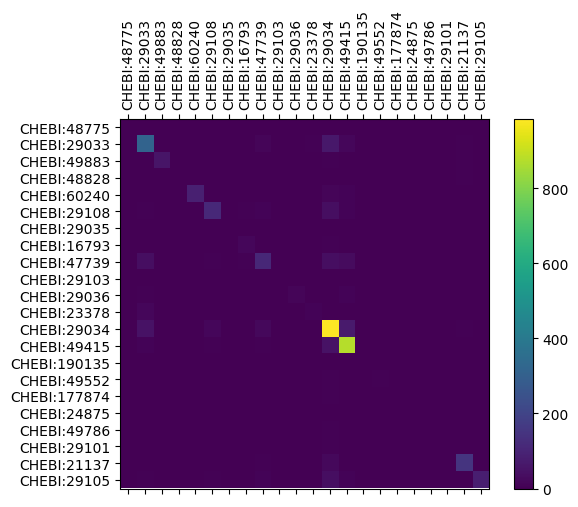

In [29]:
plot_confusion(m, unique_labels=labels)

#### **Conclusion**

Predicting metal binding sites is a complex and challenging problem. This case study illustrates a typical pipeline for constructing a machine learning model specifically designed for predicting the metal ions that bind to particular binding sites. To accomplish this, we leverage pre-existing sequence embeddings obtained from UniProtKB SwissProt, which were generated using ProtT5, a transformer-based large language model. In this case study, sinusoidal position encoding is employed to incorporate positional information.

It's important to note that the model presented in this case study is not extensively trained, and therefore its performance may be suboptimal. However, there are several avenues for potential improvement. One approach involves exploring and tuning other hyperparameters within the model architecture. Additionally, alternative machine learning techniques, including various deep learning models, can be explored to enhance predictive performance.

By delving deeper into hyperparameter tuning and considering different machine learning approaches, we can potentially achieve improved results in predicting metal binding sites.

A great way to start is to use the [EBI Metal Binding Site Prediction Challenge](https://www.synapse.org/#!Synapse:syn50559353) data.

We would like to acknowledge following sources:
1. https://github.com/agemagician/ProtTrans
2. https://towardsdatascience.com/transformers-explained-visually-part-1-overview-of-functionality-95a6dd460452
3. https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
4. https://github.com/DeepChainBio/bio-transformers/tree/main
